In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Cloning into 'dl_basics'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 115 (delta 42), reused 78 (delta 23), pack-reused 0
Receiving objects: 100% (115/115), 1.28 MiB | 1.43 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Found GPU: Tesla T4.


In [2]:
!pip install keras-nlp --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 49.9 MB/s eta 0:00:00


In [3]:
from data_gen.modulo_arithmetic import addition_modulo_data
#import models
import utils

In [11]:
P = {}

P["addition_modulo_data"] = {
    "p_max" : 113,
    "train_size" : 0.3,
    "add_equal_sign" : True,
    "seed" : 42,
}

x_train, x_val, y_train, y_val = addition_modulo_data(**P["addition_modulo_data"])
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
print(x_train[0], y_train[0])

(3830, 3) (8939, 3) (3830,) (8939,)
[ 24  37 113] 61


In [12]:
import tensorflow as tf
from keras import Model, Input
from keras.layers import Embedding, Dense
from keras_nlp.layers import PositionEmbedding, TransformerEncoder


def build_model(
        seq_len,
        vocab_size,
        embed_dim,
):
    inp = Input(shape=(seq_len,))

    token_emb = Embedding(vocab_size, embed_dim)(inp)
    pos_emb = PositionEmbedding(seq_len)(token_emb)
    x = token_emb + pos_emb

    x = TransformerEncoder(
        intermediate_dim=embed_dim * 4,
        num_heads=4,
        dropout=0,
        activation="relu",
        normalize_first=False,
    )(x)

    x = Dense(vocab_size, use_bias=False)(x)

    out = x[:, -1, :]

    model = Model(inp, out, name="transf_keras_nlp")
    return model

In [13]:
# init new run

P["model_name"] = "transformer_keras_nlp"
P["model_build_params"] = {
    "seq_len" : 3,
    "vocab_size" : P["addition_modulo_data"]["p_max"] + 1, # + 1 for the "=" sign
    "embed_dim" : 128,
}

model = build_model(**P["model_build_params"])

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    #optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-3, weight_decay=1),
    metrics = [ "accuracy" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
print("Run dir :", P["run_dir"])

run = utils.TrainingRun()

Model: "transf_keras_nlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 3, 128)       14592       ['input_2[0][0]']                
                                                                                                  
 position_embedding_1 (Position  (None, 3, 128)      384         ['embedding_1[0][0]']            
 Embedding)                                                                                       
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 3, 128)      0           ['embedding_1[0][0

In [14]:
NUM_EPOCHS = 1024*4
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    x_train, y_train,
    epochs = NUM_EPOCHS,
    batch_size = len(x_train),
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

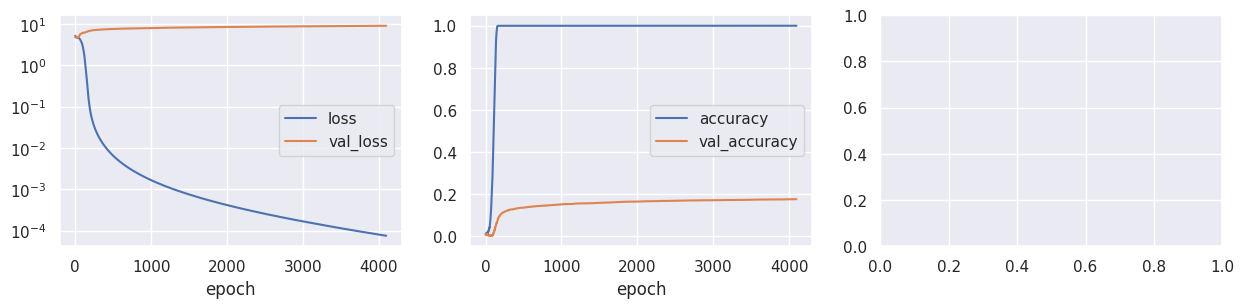

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);
#axs[1].set_ylim(0,0.2);

#sns.lineplot(data=run.history[["lr"]], ax=axs[2], dashes=False);

In [ ]:
#model.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics = [ "mae" ]
)

In [ ]:
#run.save_state(os.path.join(OUTPUT_DIR, P["run_dir"]), P, model)

In [ ]:
#P, model = run.load_state("../output/gru_01-230407-220913")

In [9]:
y_pred = model.predict(x_val)
y_pred.shape

100/100 [==============================] - 0s 3ms/step


(3193, 114)

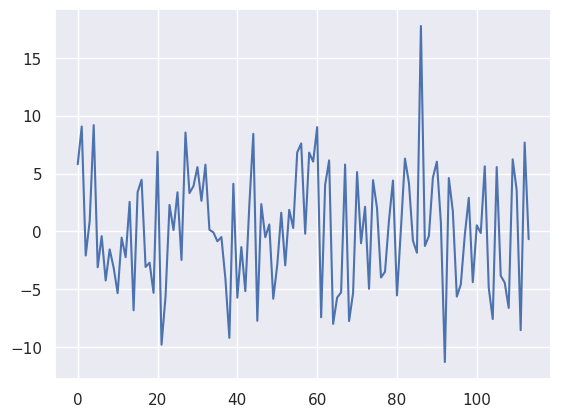

In [10]:
plt.plot(y_pred[0])
#plt.plot(y)